In [145]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import pandas as pd

# import main data
data_lcparam = pd.read_csv("lcparam_DS17f.txt", sep=" ")
# import systematic error
data_sys = pd.read_csv("sys_DS17f.txt", sep=" ")
data_sys.columns = ["sys_error"]
sys_error_data = np.reshape(pd.Series.to_numpy(data_sys.sys_error), (40, 40))

from core_mcmc_functions import chain

In [146]:
from prior_likelihood import likelihood
from prior_likelihood import prior

def sys_error_likelihood(params, data):
    return likelihood(params, data, sys_error=sys_error_data)

In [147]:
#good variances [.1,.1,1,?]
chn, rej = chain(data_lcparam, 5000, 1000, .001, start_state=[.4, .6, 75, -19.23], variances=[.03, .03, 0, .0], prior_mode='uniform' )
#chn, rej = chain(data_lcparam, 1000, 200, .01, start_state=[.5, .7, 65, -20], variances=[.01, .01, .25, .1], prior_mode='M prior', likelihood_func= sys_error_likelihood )

total trials:2997. accepted 40.2% of trials


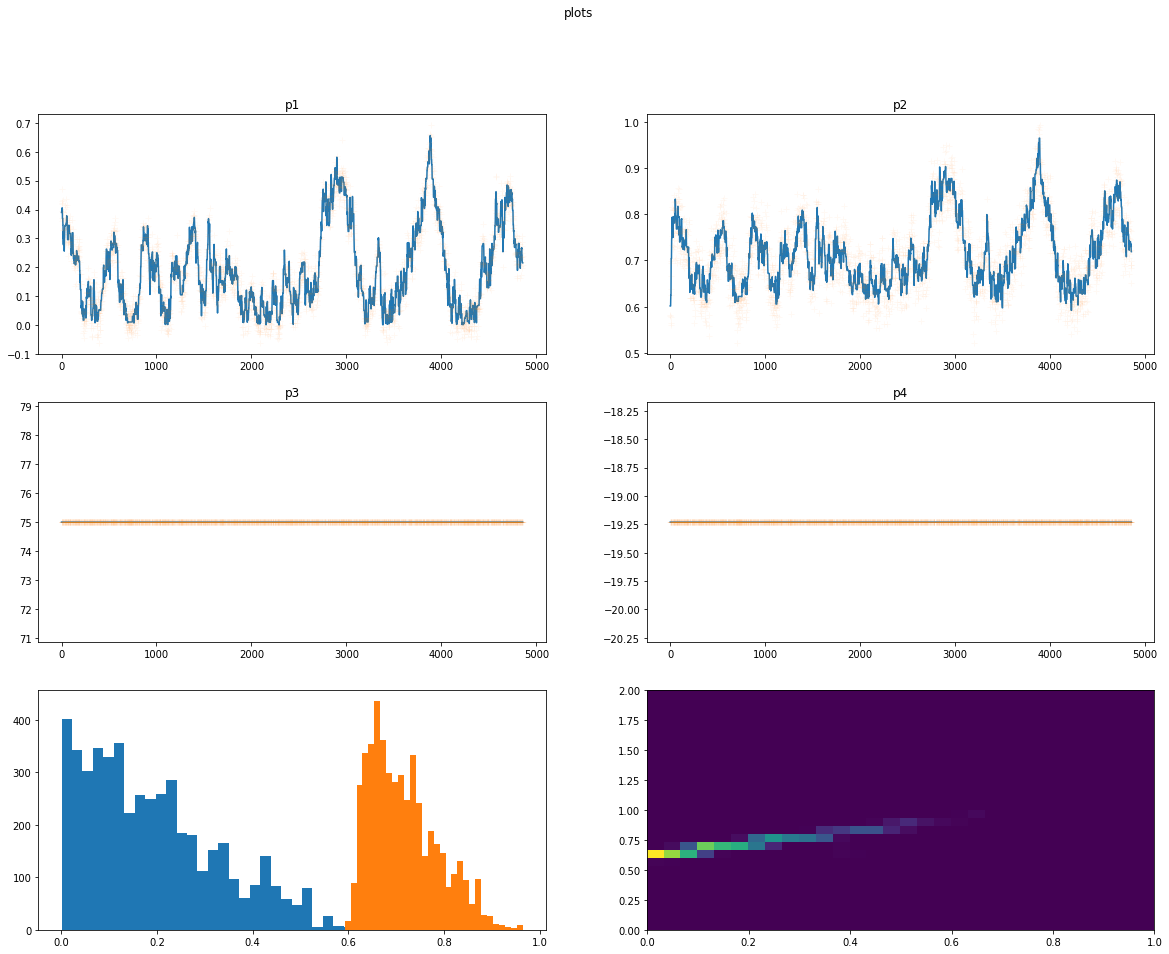

In [63]:
plot_rejects=True
fig,ax = plt.subplots(3,2, figsize=(20,15))
fig.suptitle('plots')

ax[0,0].plot(chn[:,0])
ax[0,0].set_title('p1')
ax[0,1].plot(chn[:,1])
ax[0,1].set_title('p2')
ax[1,0].plot(chn[:,2])
ax[1,0].set_title('p3')
ax[1,1].plot(chn[:,3])
ax[1,1].set_title('p4')
if plot_rejects==True:
    rej_a = 200/len(rej[:,0])
    ax[0,0].plot(rej[:,0], '+', alpha=rej_a)
    ax[0,1].plot(rej[:,1], '+', alpha=rej_a)
    ax[1,0].plot(rej[:,2], '+', alpha=rej_a)
    ax[1,1].plot(rej[:,3], '+', alpha=rej_a)
    
ax[2,0].hist(chn[:,0],bins=30);
ax[2,0].hist(chn[:,1], bins=30);
ax[2,1].hist2d(chn[:,0],chn[:,1], bins=30, range=[[0, 1], [0, 2]]);

In [141]:
def likelihood_test(resolution, p1_min, p1_max, p2_min, p2_max, p1_slice=.25, p2_slice=.75, two_d=True):
    p1= np.linspace(p1_min,p1_max,resolution)
    p2= np.linspace(p2_min,p2_max,resolution)
    p1_lik=np.zeros(resolution)
    p2_lik=np.zeros(resolution)

    for i, p1_item in enumerate(p1):
            p1_lik[i]= likelihood([p1_item,p2_slice,74,-19.23], data_lcparam)
    for j,p2_item in enumerate(p2):
        p2_lik[j] = likelihood([p1_slice,p2_item,74,-19.23], data_lcparam)
            
    fig, ax =plt.subplots(2, figsize=(5,8))
    ax[0].plot(p1,p1_lik)
    ax[0].set_title('likelihood of p1 when p2={}'.format(p2_slice))
    ax[1].plot(p2,p2_lik)
    ax[1].set_title('likelihood of p2 when p1={}'.format(p2_slice))
    
    if two_d:
        x, y = np.meshgrid(p1,p2)
        likelihood_array=np.zeros((resolution,resolution))
        for i, p1_item in enumerate(p1):
            for j,p2_item in enumerate(p2):
                likelihood_array[i,j]= likelihood([p1_item,p2_item,74,-19.23], data_lcparam)
    return(x, y, likelihood_array)


/Users/kray/Documents/UCD/Misc_Classes/Data_Science/DS4S_group01_SNproject/theoretical_mag.py:71: RuntimeWarning: invalid value encountered in double_scalars
  (OmegaK*((1+x)**2)))**-0.5
/Users/kray/Documents/UCD/Misc_Classes/Data_Science/DS4S_group01_SNproject/theoretical_mag.py:72: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  eta, etaerr = integrate.quad(f, 0.0, SNdata['zhel'][i])


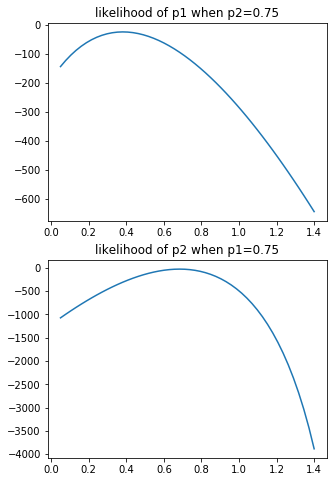

In [142]:
x,y,z = likelihood_test(50,.05,1.4, .05, 1.4)

Text(0.5, 1.0, 'log_likelihood when H0 and M are set')

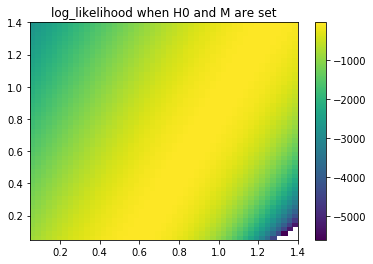

In [144]:
fig, ax = plt.subplots(1)
c = ax.pcolor(x, y, z)
fig.colorbar(c, ax=ax)
ax.set_title('log_likelihood when H0 and M are set')